In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [2]:
import os
import numpy as np

import pandas as pd
import cudf as gd

from cuml.manifold.umap import UMAP as cumlUMAP

In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.autonotebook import tqdm

In [5]:
DATASET_ID = 'mouse_usv_long'

In [6]:
window_length_ms = 100
hop_length_ms = 1
window_length_frames = int(window_length_ms / hop_length_ms)
window_length_frames

100

### load data

In [30]:
windows_loc = DATA_DIR/'umap_windows' / DATASET_ID / ('windows_' + str(window_length_ms)+'.npy')
windows  = np.load(windows_loc.as_posix())
np.shape(windows)

(204535, 3200)

In [77]:
spec_loc = DATA_DIR/'umap_windows' / DATASET_ID / ('spec.npy')
spec_large  = np.load(spec_loc.as_posix())
np.shape(spec_large)

(820, 204634)

In [88]:
spec_loc = DATA_DIR/'umap_windows' / DATASET_ID / ('spec_small.npy')
spec  = np.load(spec_loc.as_posix())
np.shape(spec)

(32, 204634)

In [89]:
onsets_loc = DATA_DIR/'umap_windows' / DATASET_ID / ('onsets_offsets.npy')
onsets, offsets  = np.load(onsets_loc.as_posix())
np.shape(onsets), np.shape(offsets)

((1590,), (1590,))

In [90]:
excess = (np.shape(spec)[1] - len(windows))
excess

99

In [97]:
#spec = spec[:, (int(np.ceil(excess/2))):-int(np.floor(excess/2))]
spec = spec[:, :-int(excess)]

In [98]:
np.shape(spec)

(32, 204535)

### plot spec

In [93]:
rate = 250000

In [94]:
from vocalseg.utils import butter_bandpass_filter, spectrogram, int16tofloat32, plot_spec

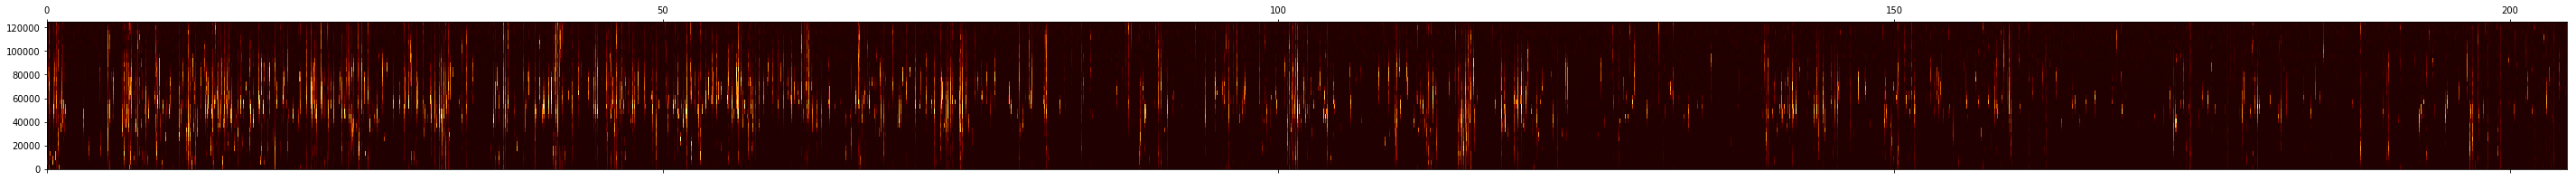

In [95]:
fig, ax = plt.subplots(figsize=(50,3))
plot_spec(spec, fig, ax, rate = rate, hop_len_ms= hop_length_ms, show_cbar=False);
plt.show()

In [110]:
from avgn.visualization.spectrogram import draw_spec_set

In [154]:
segs = [
    spec[:, int(onset * 1000 / hop_length_ms) : int(offset * 1000 / hop_length_ms)]
    for oi, (onset, offset) in tqdm(enumerate(zip(onsets, offsets)))
]
#segs = [norm(i) for i in segs if np.prod(np.shape(i)) > 0]

1589


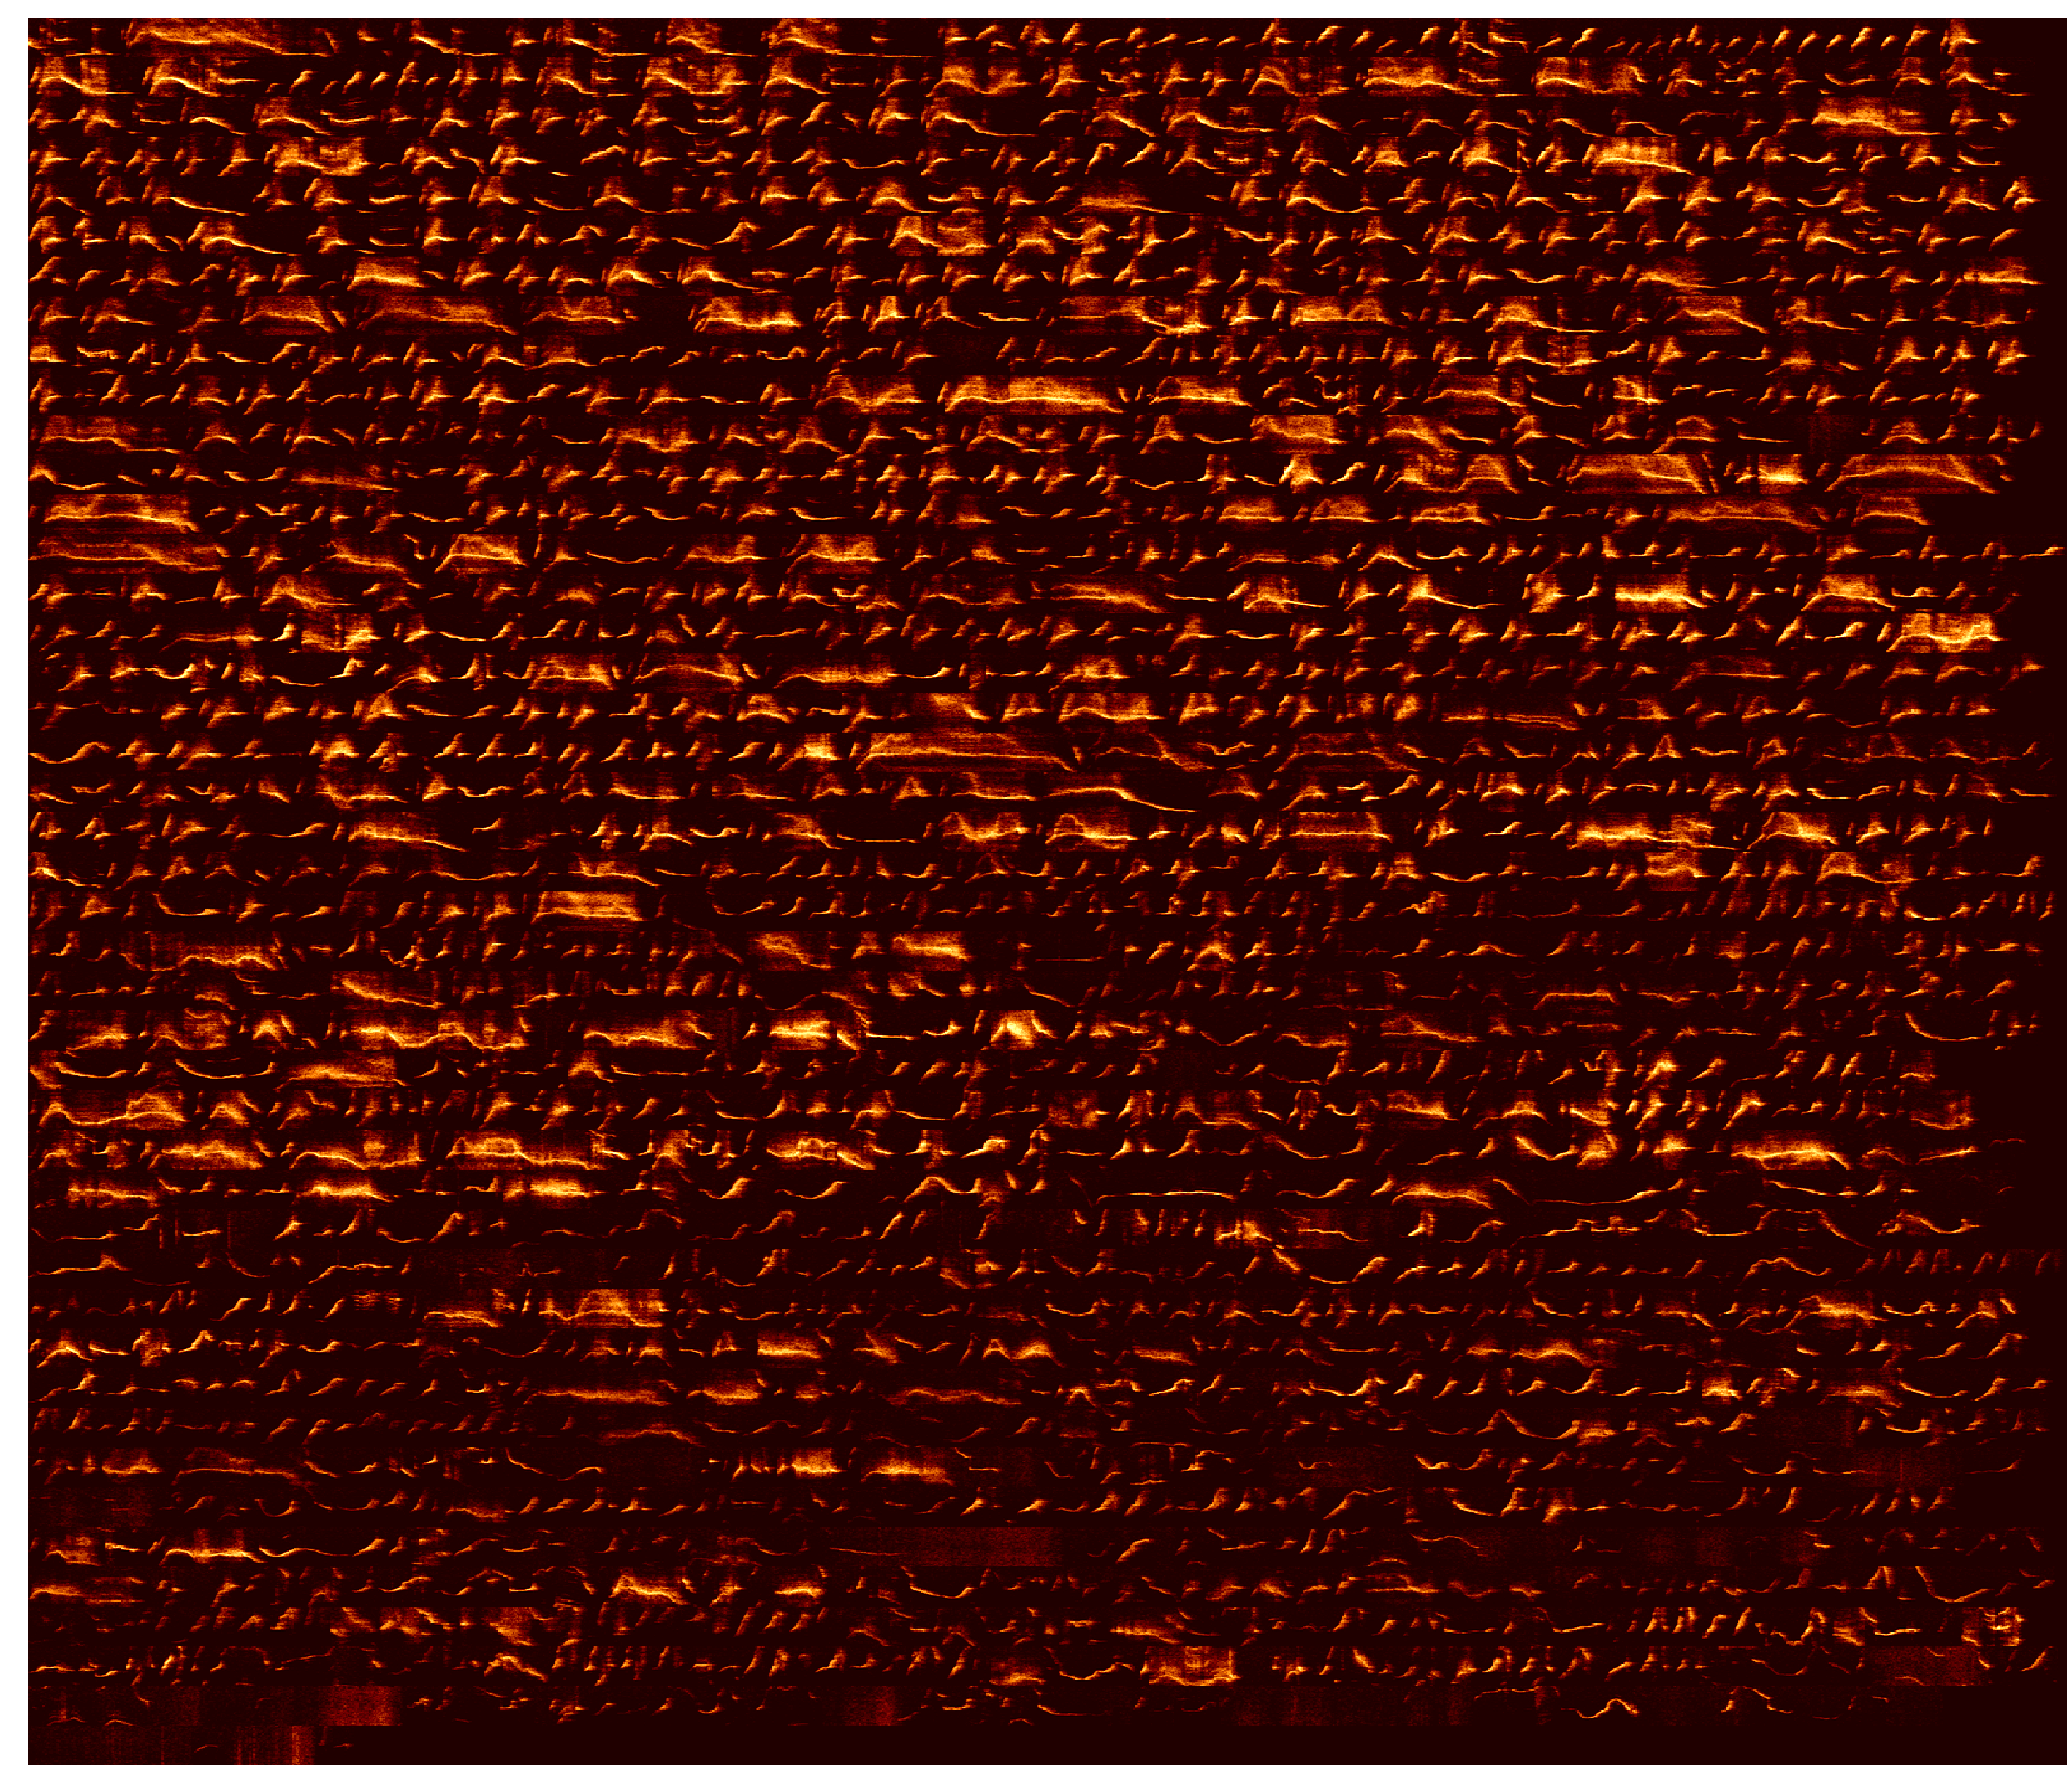

In [155]:
draw_spec_set(segs, zoom=1, maxrows=60, colsize=50)

### create embedding

In [11]:
cuml_umap = cumlUMAP(min_dist = 0.5)
embedding = cuml_umap.fit_transform(windows)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  """Entry point for launching an IPython kernel.
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  


In [12]:
np.shape(embedding), np.min(embedding, axis=0), np.max(embedding, axis=0)

((204535, 2),
 array([-1610.43347168,  -989.63183594]),
 array([3114.15209961, 1167.03234863]))

(-15, 15)

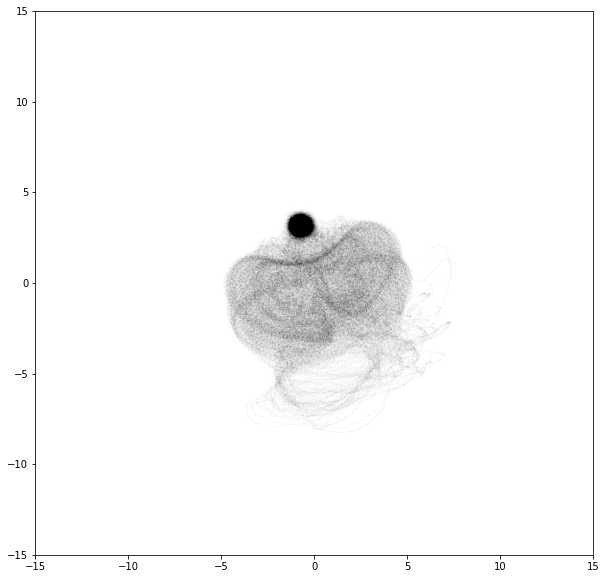

In [18]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(embedding[:,0], embedding[:,1], alpha = 0.01, s = 1, color='k')
ax.set_xlim([-15,15])
ax.set_ylim([-15,15])

In [19]:
from avgn.utils.paths import FIGURE_DIR,ensure_dir
from avgn.utils.general import save_fig

In [20]:
ensure_dir(FIGURE_DIR/'umap_seqs' / DATASET_ID)

### create power-mask for sequences

In [101]:
def norm(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

In [102]:
mask = np.expand_dims(norm(np.max(spec, axis=0)),1)
mask = (mask+1e-5)**1

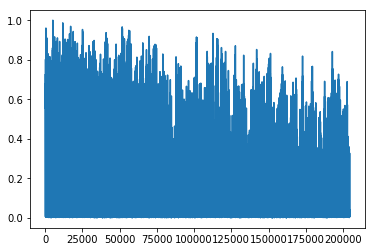

In [103]:
plt.plot(mask)

### plot seqs

In [33]:
window_z = embedding

In [34]:
xlims = [-7, 7]
ylims = [-10, 5]

(-7.0, 7.0, -10.0, 5.0)

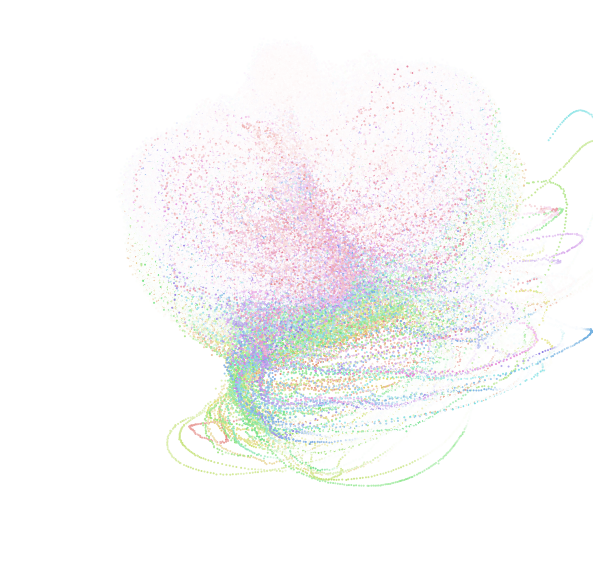

In [35]:
fig, ax = plt.subplots(figsize=(10,10))
curr_idx = 0
cols = np.array(sns.color_palette('hls', len(window_z)))
cols = 1-((1-cols) * mask) #+ (add*(mask))
ax.scatter(window_z[:,0], window_z[:,1], alpha = 1, s = 1, c= cols)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.axis('off')

#save_fig(FIGURE_DIR / 'umap_seqs' / DATASET_ID / ('umap_seqs_single_'+key), save_png=True)

### plot segments individually

(-7.0, 7.0, -10.0, 5.0)

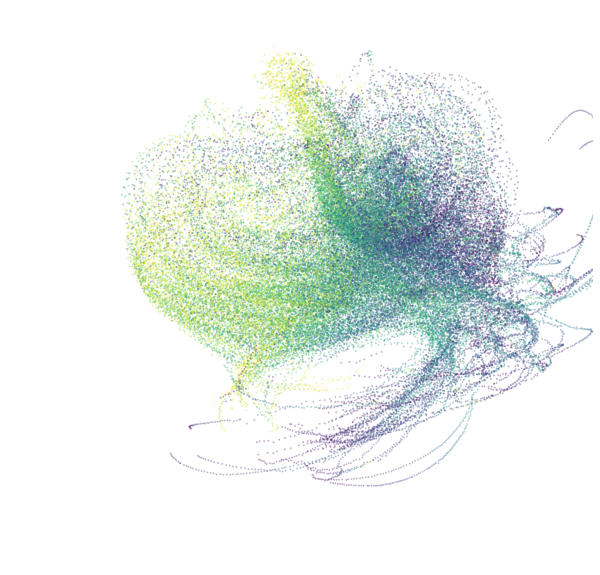

In [104]:
fig, ax = plt.subplots(figsize=(10,10))

for oi, (onset, offset) in tqdm(enumerate(zip(onsets, offsets))):
    idx_end = int(onset * 1000 / hop_length_ms)
    idx_start = int(offset * 1000 / hop_length_ms)
    seg = spec[:, idx_end:idx_start]
    window_z = embedding[idx_end:idx_start]
    cols = np.array(sns.color_palette('viridis', len(window_z)))
    ax.scatter(window_z[:,0], window_z[:,1], alpha = 0.25, s = 1, c= cols)
    #if oi == 10:
    #    break
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.axis('off')

(-7.0, 7.0, -10.0, 5.0)

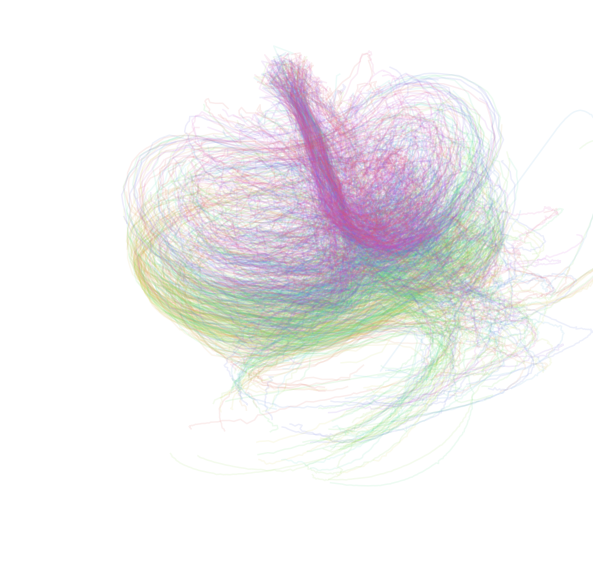

In [105]:
cols = np.array(sns.color_palette('hls', len(onsets)))
fig, ax = plt.subplots(figsize=(10,10))
for oi, (onset, offset) in tqdm(enumerate(zip(onsets, offsets))):
    idx_end = int(onset * 1000 / hop_length_ms)
    idx_start = int(offset * 1000 / hop_length_ms)
    seg = spec[:, idx_end:idx_start]
    window_z = embedding[idx_end:idx_start]
    col = cols[oi]
    ax.plot(window_z[:,0], window_z[:,1], alpha = 0.1, color= col)
    #if oi == 10:
    #    break
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.axis('off')

### plot specs with colorspace

In [166]:
import copy

z_normed = copy.deepcopy(embedding)
z_normed[z_normed > 5] = 5
z_normed[z_normed < -5] = -5
z_normed[:,0] = norm(z_normed[:,0])
z_normed[:,1] = norm(z_normed[:,1])

In [186]:
window_z = z_normed
R = norm(window_z[:,0])
G = np.ones_like(G)*.5
B = norm(window_z[:,1]) 
RGB = np.dstack((R,G,B))
RGB = [list(i) for i in np.nan_to_num(np.squeeze(RGB))]
rgb_img = np.expand_dims(RGB,0)

In [187]:
rgb_img_masked = ((rgb_img) * mask**.5)

In [188]:
np.shape(rgb_img)

(1, 204535, 3)

In [189]:
from matplotlib import gridspec
from vocalseg.utils import butter_bandpass_filter, spectrogram, int16tofloat32, plot_spec

In [190]:
np.shape(rgb_img[:,:1000,:])

(1, 1000, 3)

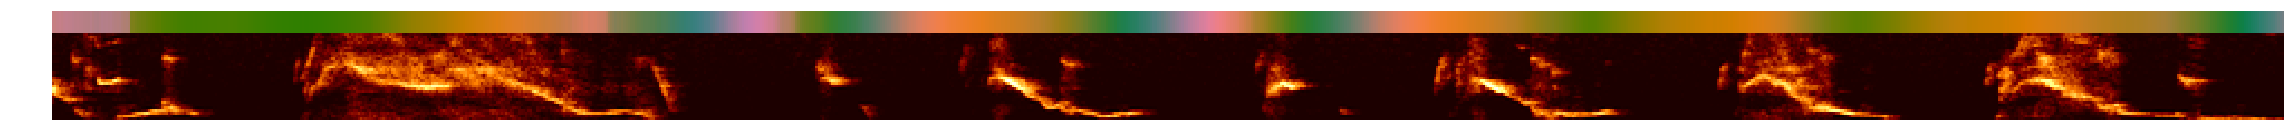

In [192]:
fig = plt.figure(figsize=(40,2)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 4], wspace=0, hspace=0) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax0.imshow(rgb_img[:,:1000,:], interpolation=None, aspect='auto')
plot_spec(spec[:,:1000], fig, ax1, rate = rate, hop_len_ms= hop_length_ms, show_cbar=False);
ax0.axis('off')
ax1.axis('off')
ax0.set_axis_off()
ax1.set_axis_off()